In [1]:
import warnings
warnings.filterwarnings('ignore')
import pyterrier as pt

if not pt.java.started():
    pt.java.init()

import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', False)

from pyterrier_t5 import MonoT5ReRanker

dataset_name = 'msmarco-passage'
eval_ds_name = 'dev'
dataset = pt.get_dataset(f'irds:{dataset_name}')
eval_dataset = pt.get_dataset(f'irds:{dataset_name}/{eval_ds_name}')
topics = eval_dataset.get_topics()
qrels = eval_dataset.get_qrels()

work_name = "retrievability-bias"
root_dir = f'/root/{work_name}'
nfs_save = f'/nfs/datasets/cxj/{work_name}'
if not os.path.exists(nfs_save):
    os.makedirs(nfs_save)

Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.10 (build: craigm 2024-08-22 17:33), helper_version=0.0.8]


In [ ]:
def create_indexes():
    index_file = f"{root_dir}/{dataset_name}-nostemmer-nostopwords-index"
    nfs_index_file = f"{nfs_save}/{dataset_name}-nostemmer-nostopwords-index"
    if os.path.exists(index_file):
        index_ref = pt.IndexRef.of(index_file)
    else:
        if os.path.exists(nfs_index_file):
            os.system(f'cp -r {nfs_index_file}/ {root_dir}/')
            print(f'copied from {nfs_save}')
            index_ref = pt.IndexRef.of(index_file)
        else:
            print(f"indexing into {index_file}")
            indexer = pt.IterDictIndexer(index_file, stemmer=pt.TerrierStemmer.none, stopwords=pt.TerrierStemmer.none, blocks=True, verbose=True)
            index_ref = indexer.index(dataset.get_corpus_iter(verbose=True))
            os.system(f'cp -r {index_file} {nfs_save}/')
            print(f'copied index into {nfs_save}')

    index = pt.IndexFactory.of(index_ref)
    return index

def retrieve_bm25_monot5():
    index = create_indexes()
    monoT5 = MonoT5ReRanker() # loads castorini/monot5-base-msmarco by default
    bm25 = pt.terrier.Retriever(index, wmodel="BM25") % 100
    mono_pipeline = bm25 >> pt.text.get_text(dataset, "text") >> monoT5
    print('start retrieval')
    result = mono_pipeline.transform(topics)

    csv = f'results_bm25_monot5_r100.csv'
    result.to_csv(f'{root_dir}/{csv}')
    os.system(f'cp -r {root_dir}/{csv} {nfs_save}/')
    print(f'copied {root_dir}/{csv} into {nfs_save}')

retrieve_bm25_monot5()
print('done')

indexing into /nfs/datasets/cxj/bm25/msmarco-passage-nostemmer-nostopword-index


msmarco-passage documents:   6%|▌         | 499409/8841823 [00:40<08:29, 16382.45it/s] 

22:07:35.770 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (500080) - further warnings are suppressed


msmarco-passage documents:  12%|█▏        | 1036230/8841823 [01:18<07:47, 16700.69it/s]

In [2]:
result = pd.read_csv('/nfs/primary/retrievability-bias/results_bm25_10.csv')
g = result.groupby(['docid'])['docid'].count()
df_g = pd.DataFrame(g)
df_g.index.name='inx'
df_g = df_g.sort_values(by='docid')
df_g = df_g.rename(columns = {'docid':'count'})

In [3]:
df_g.shape

(27, 1)

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from matplotlib.pyplot import FixedLocator
import matplotlib as mpl
from matplotlib import cycler
from matplotlib import cm

In [5]:
total = df_g['count'].sum()
total

100

In [9]:
x_num = df_g.shape[0] + 5
x0 = [i for i in range(0,x_num,5)]
equality_list = [1 for i in range(0,x_num,1)]
y0 = [sum(equality_list[:i])/df_g.shape[0] for i in x0]

In [10]:
x0

[0, 5, 10, 15, 20, 25, 30]

In [11]:
y0

[0.0,
 0.18518518518518517,
 0.37037037037037035,
 0.5555555555555556,
 0.7407407407407407,
 0.9259259259259259,
 1.1111111111111112]

In [12]:
x = x0
y = [df_g[0:i+1]['count'].sum()/total for i in x]

In [13]:
y

[0.01, 0.06, 0.11, 0.16, 0.47, 0.91, 1.0]

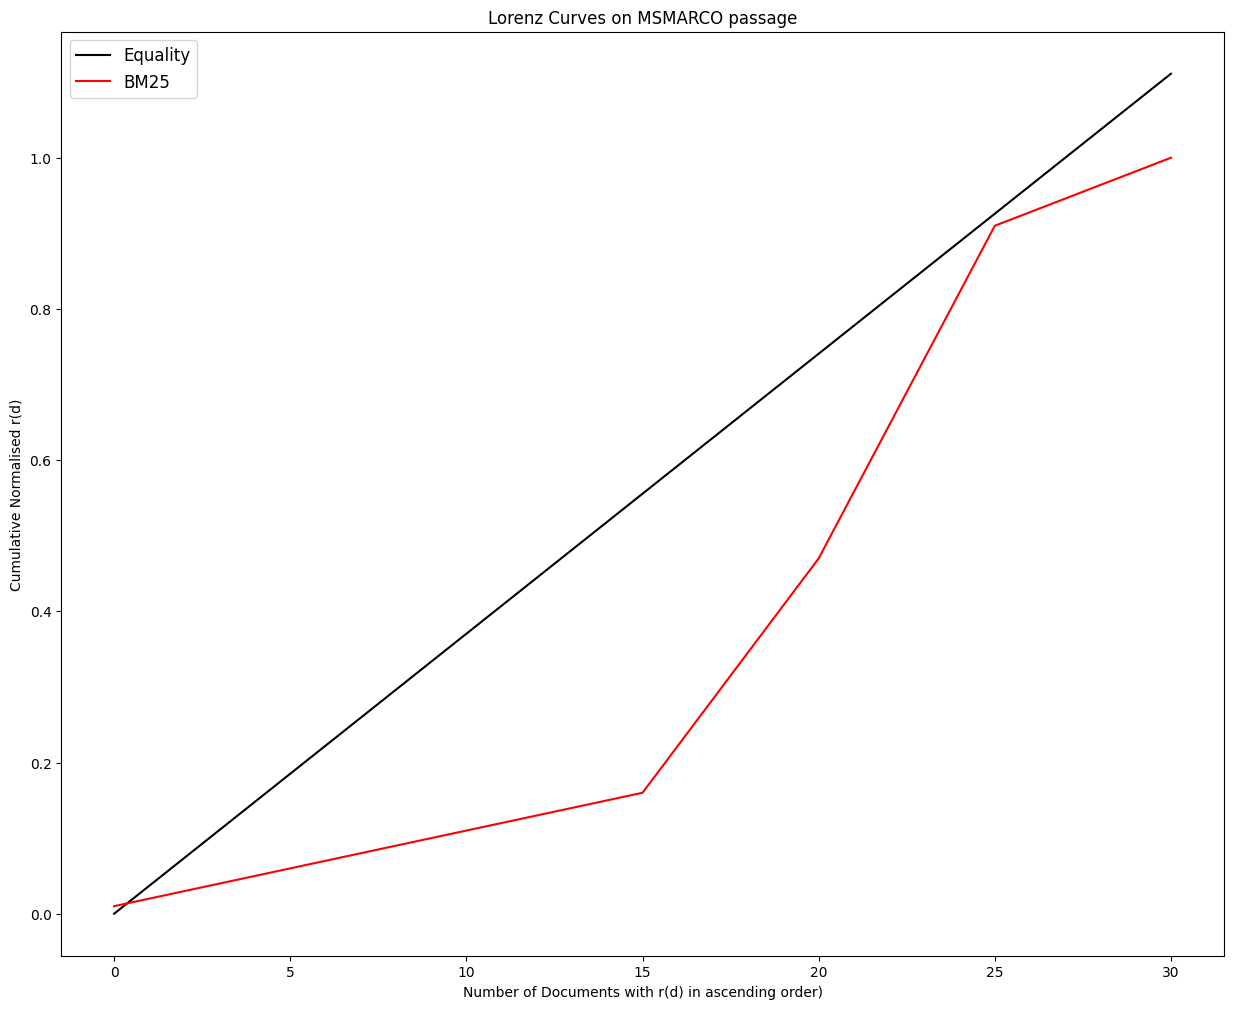

In [14]:
fig1,ax = plt.subplots(1,1, figsize=(15,12))
# plt.xscale('log')
ax.plot(x0,y0,color='black', linestyle='solid', marker='None', label='Equality')
ax.plot(x,y,color='red', linestyle='solid', marker='None', label='BM25')
# ax.plot(x2,y2,color='blue', linestyle='solid', marker='None', label='TF-IDF')

ax.set_title('Lorenz Curves on MSMARCO passage')
ax.set_xlabel('Number of Documents with r(d) in ascending order)')
ax.set_ylabel('Cumulative Normalised r(d)')

ax.legend(prop = {'size':12})

plt.show()